In [41]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import little_mallet_wrapper as lmw

In [42]:
data_directory_path   = '/Volumes/Passport-1/data/birth-control'
output_directory_path = '/Volumes/Passport-1/output/birth-control'

<br><br>

# Load datasets (Reddit, WebMD, Twitter)

## Reddit

In [43]:
reddit_posts_df = pd.read_csv(data_directory_path + '/final-data/reddit_posts.csv')
reddit_comments_df = pd.read_csv(data_directory_path + '/final-data/reddit_comments.csv')

In [44]:
len(reddit_posts_df.index), len(reddit_comments_df.index)

(68958, 264912)

In [45]:
reddit_comments_df.sample(3)

,Unnamed: 0,id,parent_id,created_utc,text,tokens_text,text_type,year,month,source
9205,603,c9da2if,t1_c9czwym,1.365713e+09,Interesting. Thanks for the reply and info! I ...,interesting thanks reply info kind feel like m...,iud,2013,4,reddit-comments
106156,2441,e87ayv7,t3_9q7b3w,1.540160e+09,I’m not sure but when I asked my doctor if I c...,m sure asked doctor could take one old bc pill...,pill,2018,10,reddit-comments
91249,2123,dhhmoj6,t1_dhhb98q,1.494635e+09,"Thanks, I did some more posing and eventually ...",thanks posing eventually found didn think woul...,iud,2017,5,reddit-comments


In [46]:
reddit_posts_df.sample(3)

,Unnamed: 0,id,created_utc,text,title,year,month,url,link_flair_text,tokens_text,text_type,source
5002,243,2cqiab,1407280896,...her libido will decrease. I read a lot abou...,"My girlfriend wants to start birth control, bu...",2014,8,http://www.reddit.com/r/birthcontrol/comments/...,NaN,girlfriend wants start birth control m worried...,pill,reddit-posts
748,36,v5kl1,1339884340,I was on Trivora for two years. But they disco...,Gildess FE 1/20 vs. Trivora (Enpresse). Any la...,2012,6,http://www.reddit.com/r/birthcontrol/comments/...,NaN,gildess fe NUM/NUM vs trivora enpresse ladies ...,pill,reddit-posts
6234,253,3weo9z,1449858024,"Hi there, \n\nSo I was just curious if getting...",Are withdrawal bleeds a sufficient indicator?,2015,12,https://www.reddit.com/r/birthcontrol/comments...,NaN,withdrawal bleeds sufficient indicator hi curi...,pill,reddit-posts


## WebMD

In [47]:
webmd_df = pd.read_csv(data_directory_path + '/final-data/webmd.csv')

In [48]:
len(webmd_df.index)

18110

In [49]:
webmd_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,date,year,text,name,title,source,text_type,num_tokens,tokens_text
6309,6309,7342,7342,w7511,2008-05-21,2008,I recently switched to this bc pill after bein...,loestrin-24-fe-tablet,NaN,webmd-reviews,pill,49,recently switched bc pill yaz NUM years absolu...
2710,2710,3674,3674,w3764,2008-04-13,2008,I just finished my first pack of Femcon Fe. I...,femcon-fe-tablet-chewable,NaN,webmd-reviews,pill,75,finished first pack femcon fe extremely easy t...
7757,7757,8808,8808,w9008,2014-09-05,2014,I'm adding on to a review from a few months ag...,minastrin-24-fe,NaN,webmd-reviews,pill,167,m adding review months ago medicine NUM months...


## Twitter

In [50]:
twitter_posts_df = pd.read_csv(data_directory_path + '/final-data/twitter_posts.csv')
twitter_replies_df = pd.read_csv(data_directory_path + '/final-data/twitter_replies.csv')

In [51]:
len(twitter_posts_df.index), len(twitter_replies_df.index)

(499796, 211896)

In [52]:
twitter_posts_df.sample(3)

,Unnamed: 0,source,text,tokens_text,date,year,month,id,conversation_id,retweet_count,reply_count,like_count,quote_count,text_type,num_tokens
43335,51028,twitter-posts,"Mom loses ovaries, uterus and toes after IUD e...",mom loses ovaries uterus toes iud ends stomach...,2018-06-10T02:53:24.000Z,2018,6,1005644066346979328,1005644066346979328,0,0,0,0,iud,11
15046,17184,twitter-posts,i pissed off the ladies at the front desk LMFA...,pissed ladies front desk lmfao jus wanna get i...,2019-06-04T19:23:29.000Z,2019,6,1135990475784171521,1135990475784171521,0,1,12,0,iud,11
461178,580094,twitter-posts,RT Birth Control Pill = 2nd best thing that w...,rt birth control pill NUMnd best thing women p...,2010-10-20T06:30:58.000Z,2010,10,27907571423,27907571423,0,0,0,0,pill,13


In [53]:
twitter_replies_df.sample(3)

,Unnamed: 0,source,text,tokens_text,text_type,date,year,month,id,conversation_id,retweet_count,reply_count,like_count,quote_count,num_tokens
125375,162631,twitter-replies,"Whoa, for second I thought you were giving aw...",whoa second thought giving away iud pretty green,iud,2010-04-12T20:37:25.000Z,2010,4,12064794167,12064758525,0,0,0,0,8
177321,232730,twitter-replies,I had excruciating pains as well. The gynae s...,excruciating pains well gynae still find wrong...,pill,2020-02-23T16:52:10.000Z,2020,2,1231622791499304961,1231461899985981440,0,1,0,0,13
200432,260162,twitter-replies,Y or N or oral birth control and other app...,oral birth control appendages,pill,2013-12-31T18:20:02.000Z,2013,12,418084143877337088,418077305404014594,0,1,0,0,4


<br><br><br><br>

# Get overall method distributions

In [54]:
reddit_posts_df['text_type'].value_counts()

pill       36921
iud        24657
implant     7380
Name: text_type, dtype: int64

In [55]:
reddit_comments_df['text_type'].value_counts()

iud        117631
pill       117283
implant     29998
Name: text_type, dtype: int64

In [56]:
twitter_posts_df['text_type'].value_counts()

pill       226762
iud        217728
implant     55306
Name: text_type, dtype: int64

In [57]:
twitter_replies_df['text_type'].value_counts()

iud        147680
pill        39039
implant     25177
Name: text_type, dtype: int64

In [58]:
webmd_df['text_type'].value_counts()

pill       14873
iud         2354
implant      883
Name: text_type, dtype: int64

<br><br>

# Plot distributions over years

In [59]:
name_df_dict = {'reddit_posts': reddit_posts_df,
                'reddit_comments': reddit_comments_df,
                'twitter_posts': twitter_posts_df,
                'twitter_replies': twitter_replies_df,
                'webmd_reviews': webmd_df}

name_label_dict = {'reddit_posts': 'Reddit Posts',
                   'reddit_comments': 'Reddit Comments',
                   'twitter_posts': 'Twitter Posts',
                   'twitter_replies': 'Twitter Replies',
                   'webmd_reviews': 'Webmd Reviews'}    

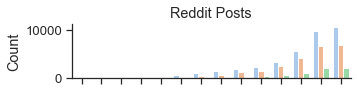

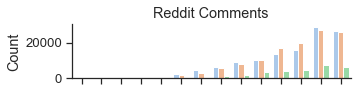

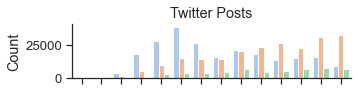

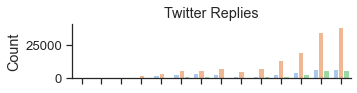

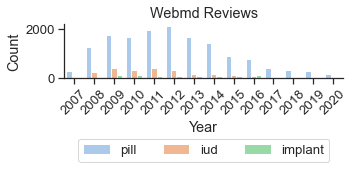

In [60]:

for _name, _df in name_df_dict.items():

    plt.figure(figsize=(5,1))
    ax = sns.countplot(data=_df,
                    x='year',
                    hue='text_type',
                    palette='pastel',
                    hue_order=['pill', 'iud', 'implant'],
                    order=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
    sns.despine()
    plt.ylabel('Count')
    if _name == 'webmd_reviews':
        plt.xlabel('Year')
        plt.xticks(rotation=45)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -1),ncol=3)
    else:
        ax.set_xticklabels([])
        ax.get_legend().remove()
        plt.xlabel('')
    plt.title(name_label_dict[_name])
    plt.savefig(output_directory_path + '/plots/bc-type-distributions/barplot.bc_type_dist.' + _name + '.pdf', bbox_inches='tight')

In [61]:
combined_df = pd.concat([reddit_posts_df, reddit_comments_df, twitter_posts_df, twitter_replies_df, webmd_df])
len(combined_df)

1063672

In [62]:
combined_df['source'].value_counts()

twitter-posts      499796
reddit-comments    264912
twitter-replies    211896
reddit-posts        68958
webmd-reviews       18110
Name: source, dtype: int64

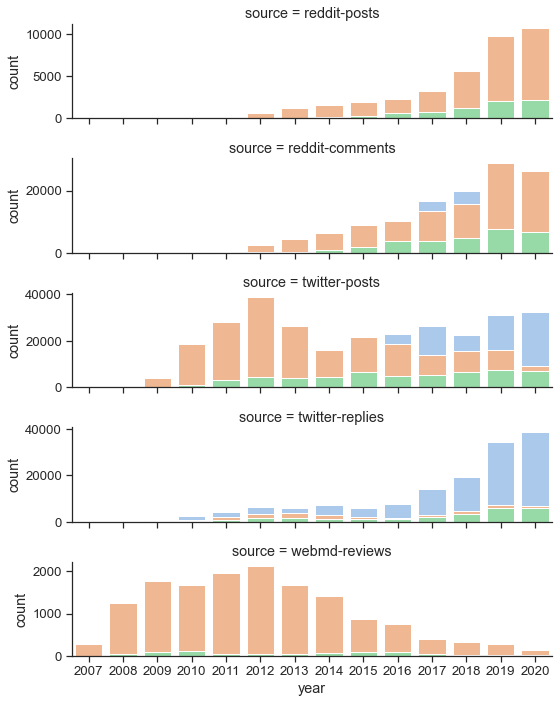

In [63]:
g = sns.FacetGrid(combined_df, row="source", hue='text_type', palette='pastel', height=2, aspect=4, sharey=False)
g.map_dataframe(sns.countplot, 'year', order=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

<br><br>

# Plot distributions normalized by year

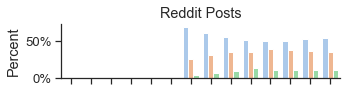

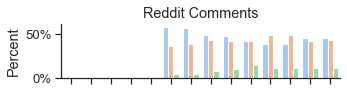

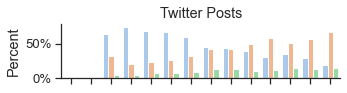

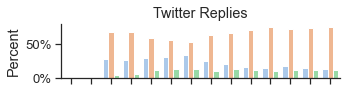

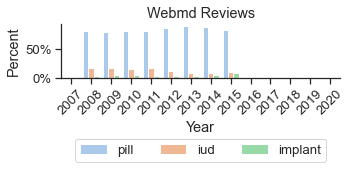

In [64]:
            

for _name, _df in name_df_dict.items():

    _dicts_to_plot = []
    for _year in [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]:
        _year_df = _df[_df['year'] == _year]
        if len(_year_df.index) > 1000:
            for _method in ['pill', 'iud', 'implant']:
                _dicts_to_plot.append({'Year': _year,
                                       'Method': _method,
                                       'Percent': 100 * (len(_year_df[_year_df['text_type'] == _method].index) / float(len(_year_df.index)))})
    _df_to_plot = pd.DataFrame(_dicts_to_plot)

    plt.figure(figsize=(5,1))
    ax = sns.barplot(data=_df_to_plot,
                     x='Year',
                      y='Percent',
                      hue='Method',
                      palette='pastel',
                      hue_order=['pill', 'iud', 'implant'],
                      order=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
    sns.despine()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    if _name == 'webmd_reviews':
        plt.xticks(rotation=45)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -1),ncol=3)
    else:
        ax.set_xticklabels([])
        ax.get_legend().remove()
        plt.xlabel('')
    plt.title(name_label_dict[_name])
    plt.savefig(output_directory_path + '/plots/bc-type-distributions/barplot.bc_type_dist.' + _name + '.normalized_by_year.pdf', bbox_inches='tight')
    plt.show()
